In [90]:
import sys

sys.path.append('/home/azhuravl/work/MonoDyGauBench_code')

from src.data import NerfiesDataModule

all_dataset = NerfiesDataModule(
    datadir='/home/azhuravl/nobackup/iphone/paper-windmill',
    eval=True,
    ratio=0.5,
    white_background=True,
    num_pts_ratio = 0.,
    num_pts =0,
    load_flow=False
)
all_dataset.setup('test')


277it [00:00, 73771.17it/s]


In [91]:
test_dataset = all_dataset.test_cameras
train_dataset = all_dataset.train_cameras

print(f"Train dataset length: {len(train_dataset)}"
      f"\nTest dataset length: {len(test_dataset)}")

Train dataset length: 277
Test dataset length: 419


In [38]:
277 + 419

696

In [35]:
data = test_dataset[100]

In [36]:
# print each variable name and the size of the tensor, dtype
for k, v in data.items():
    if hasattr(v, 'shape'):
        print(f"{k}: {v.shape}, {v.dtype}")
    else:
        print(f"{k}: {v}")

time: 0.36231884057971014
FoVx: 0.9184168372038335
FoVy: 1.1657486857390202
image_height: 480
image_width: 360
world_view_transform: torch.Size([4, 4]), torch.float32
full_proj_transform: torch.Size([4, 4]), torch.float32
camera_center: torch.Size([3]), torch.float32
original_image: torch.Size([4, 480, 360]), torch.float32
rays: torch.Size([1, 6, 480, 360]), torch.float32
image_name: 100
split: test
depth: torch.Size([480, 360]), torch.float64


In [ ]:
for i in range(len(test_dataset)):
    print(test_dataset[i]['image_name'])

100 test
Original image shape: torch.Size([4, 480, 360])
Original image dtype: torch.float32
Original image range: [0.000, 1.000]
Depth shape: torch.Size([480, 360])
Depth dtype: torch.float64
Depth range: [0.000, 1.000]


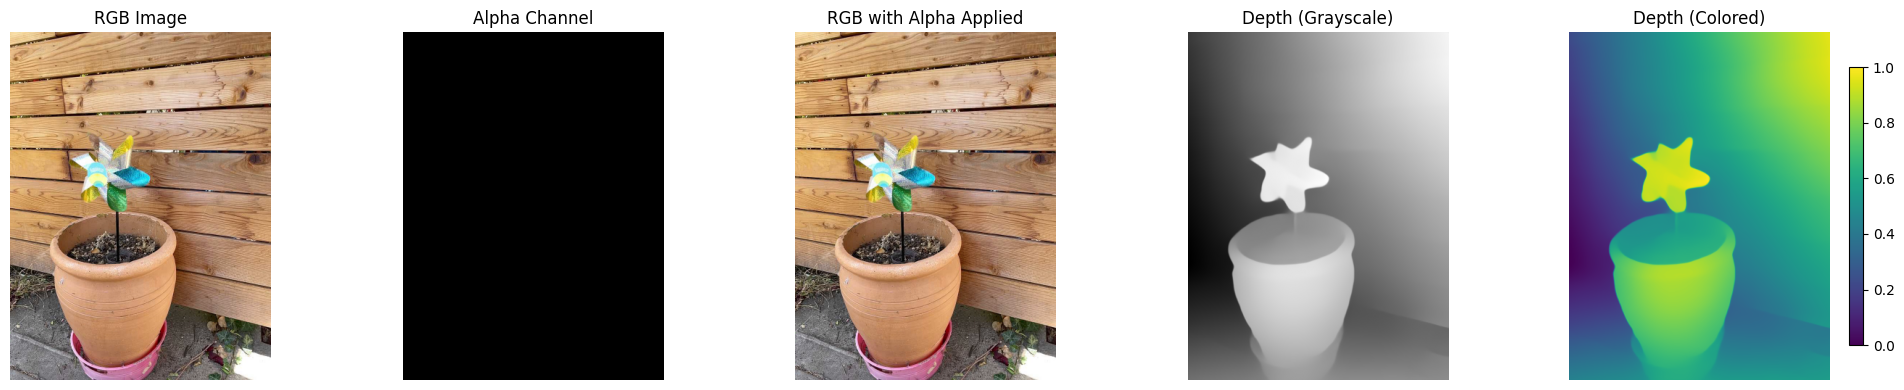


Image Statistics:
Height: 480, Width: 360
RGB range: [0.000, 1.000]
Alpha range: [1.000, 1.000]
Depth range: [0.000, 1.000]
Depth mean: 0.534, std: 0.229

Depth Analysis:
Min depth (closest): 0.000
Max depth (farthest): 1.000
Median depth: 0.536
25th percentile: 0.386
75th percentile: 0.715


In [95]:
import matplotlib.pyplot as plt
import torch
import numpy as np

data = test_dataset[100]


print(data['image_name'], data['split'])

# Get the original image and depth
original_image = data['original_image']  # Shape: [4, 480, 360]
depth = data['depth']  # Shape: [480, 360]

print(f"Original image shape: {original_image.shape}")
print(f"Original image dtype: {original_image.dtype}")
print(f"Original image range: [{original_image.min():.3f}, {original_image.max():.3f}]")
print(f"Depth shape: {depth.shape}")
print(f"Depth dtype: {depth.dtype}")
print(f"Depth range: [{depth.min():.3f}, {depth.max():.3f}]")

# The image has 4 channels (RGBA), so we need to handle this
# Take only RGB channels (first 3) and transpose to [H, W, C]
if original_image.shape[0] == 4:  # RGBA format
    rgb_image = original_image[:3].permute(1, 2, 0)  # [3, H, W] -> [H, W, 3]
    alpha_channel = original_image[3]  # [H, W] alpha channel
else:
    rgb_image = original_image.permute(1, 2, 0)  # [3, H, W] -> [H, W, 3]
    alpha_channel = None

# Convert to numpy for visualization
rgb_np = rgb_image.cpu().numpy()
alpha_np = alpha_channel.cpu().numpy() if alpha_channel is not None else None
depth_np = depth.cpu().numpy()

# Normalize if needed
if rgb_np.max() <= 1.0:
    # Already in [0, 1] range
    rgb_display = np.clip(rgb_np, 0, 1)
else:
    # Scale to [0, 1]
    rgb_display = rgb_np / rgb_np.max()

# Create visualization - now with 5 subplots to include depth
fig, axes = plt.subplots(1, 5 if alpha_np is not None else 2, figsize=(20, 4))

if alpha_np is not None:
    # Show RGB, Alpha, RGB with alpha applied, Depth, and Depth colorized
    axes[0].imshow(rgb_display)
    axes[0].set_title('RGB Image')
    axes[0].axis('off')
    
    axes[1].imshow(alpha_np, cmap='gray')
    axes[1].set_title('Alpha Channel')
    axes[1].axis('off')
    
    # Apply alpha blending (white background)
    rgb_with_alpha = rgb_display.copy()
    if len(rgb_with_alpha.shape) == 3:
        for c in range(3):
            rgb_with_alpha[:, :, c] = rgb_display[:, :, c] * alpha_np + (1 - alpha_np) * 1.0  # white background
    
    axes[2].imshow(rgb_with_alpha)
    axes[2].set_title('RGB with Alpha Applied')
    axes[2].axis('off')
    
    # Show depth in grayscale
    axes[3].imshow(depth_np, cmap='gray')
    axes[3].set_title('Depth (Grayscale)')
    axes[3].axis('off')
    
    # Show depth with color map for better visualization
    depth_colored = axes[4].imshow(depth_np, cmap='viridis')  # or 'plasma', 'turbo', 'jet'
    axes[4].set_title('Depth (Colored)')
    axes[4].axis('off')
    plt.colorbar(depth_colored, ax=axes[4], shrink=0.8)
    
else:
    # Just show RGB and depth
    axes[0].imshow(rgb_display)
    axes[0].set_title('RGB Image')
    axes[0].axis('off')
    
    # Show depth with color map
    depth_colored = axes[1].imshow(depth_np, cmap='viridis')
    axes[1].set_title('Depth')
    axes[1].axis('off')
    plt.colorbar(depth_colored, ax=axes[1], shrink=0.8)

plt.tight_layout()
plt.show()

# Print some statistics
print(f"\nImage Statistics:")
print(f"Height: {rgb_np.shape[0]}, Width: {rgb_np.shape[1]}")
print(f"RGB range: [{rgb_np.min():.3f}, {rgb_np.max():.3f}]")
if alpha_np is not None:
    print(f"Alpha range: [{alpha_np.min():.3f}, {alpha_np.max():.3f}]")
print(f"Depth range: [{depth_np.min():.3f}, {depth_np.max():.3f}]")
print(f"Depth mean: {depth_np.mean():.3f}, std: {depth_np.std():.3f}")

# Additional depth analysis
print(f"\nDepth Analysis:")
print(f"Min depth (closest): {depth_np.min():.3f}")
print(f"Max depth (farthest): {depth_np.max():.3f}")
print(f"Median depth: {np.median(depth_np):.3f}")
print(f"25th percentile: {np.percentile(depth_np, 25):.3f}")
print(f"75th percentile: {np.percentile(depth_np, 75):.3f}")

In [36]:
all_dataset.train_cameras[107]['time'], all_dataset.test_cameras[22]['time'], all_dataset.test_cameras[319]['time']

(0.22573839662447256, 0.22573839662447256, 0.22573839662447256)

In [29]:
all_dataset.train_cameras[107], all_dataset.test_cameras[22]

({'time': 0.22573839662447256,
  'FoVx': 0.9088250517565507,
  'FoVy': 1.1546405038961136,
  'image_height': 480,
  'image_width': 360,
  'world_view_transform': tensor([[ 0.9916, -0.0582, -0.1152,  0.0000],
          [-0.0677, -0.9945, -0.0805,  0.0000],
          [-0.1099,  0.0876, -0.9901,  0.0000],
          [-0.0545, -0.0764,  0.2333,  1.0000]]),
  'full_proj_transform': tensor([[ 2.0299, -0.0893, -0.1152, -0.1152],
          [-0.1386, -1.5268, -0.0805, -0.0805],
          [-0.2249,  0.1345, -0.9902, -0.9901],
          [-0.1115, -0.1173,  0.2233,  0.2333]]),
  'camera_center': tensor([ 0.0765, -0.0609,  0.2317]),
  'original_image': tensor([[[0.0510, 0.0510, 0.0510,  ..., 0.9882, 0.9882, 0.9882],
           [0.0510, 0.0510, 0.0510,  ..., 0.9882, 0.9882, 0.9882],
           [0.0510, 0.0510, 0.0510,  ..., 0.9882, 0.9882, 0.9882],
           ...,
           [0.2941, 0.3216, 0.2431,  ..., 0.2039, 0.2000, 0.2157],
           [0.3686, 0.4353, 0.3608,  ..., 0.2941, 0.2196, 0.1647],
    

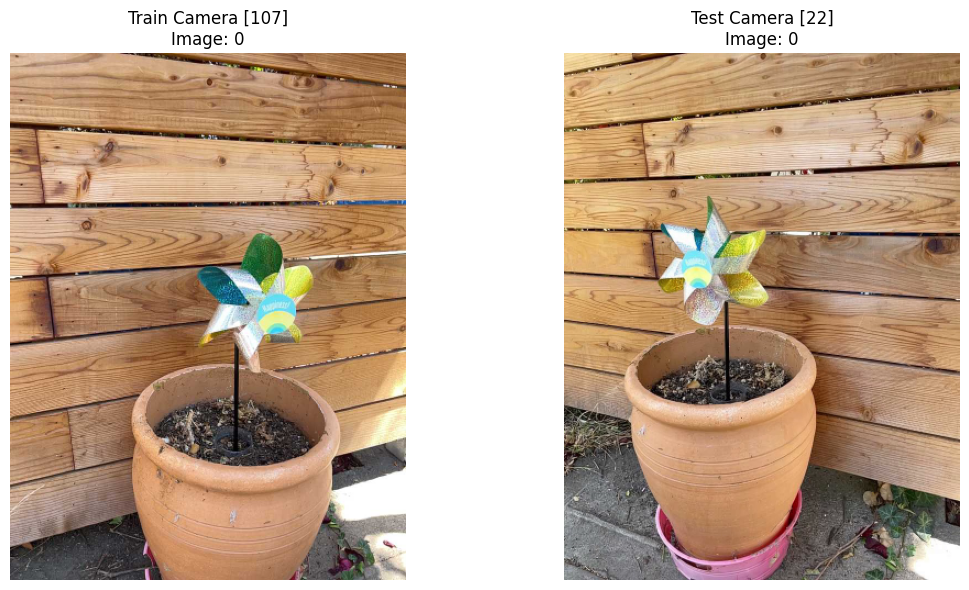

Train camera [107]: (480, 360, 3), range: [0.000, 1.000]
Test camera [22]: (480, 360, 3), range: [0.000, 1.000]


In [39]:
import matplotlib.pyplot as plt
import numpy as np

# Get the two camera data
train_cam = train_dataset[0]
test_cam = test_dataset[0]

# Extract RGB images (first 3 channels, convert to [H, W, C])
train_rgb = train_cam['original_image'][:3].permute(1, 2, 0).cpu().numpy()
test_rgb = test_cam['original_image'][:3].permute(1, 2, 0).cpu().numpy()

# Create side-by-side plot
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot train camera
axes[0].imshow(np.clip(train_rgb, 0, 1))
axes[0].set_title(f'Train Camera [107]\nImage: {train_cam["image_name"]}')
axes[0].axis('off')

# Plot test camera  
axes[1].imshow(np.clip(test_rgb, 0, 1))
axes[1].set_title(f'Test Camera [22]\nImage: {test_cam["image_name"]}')
axes[1].axis('off')

plt.tight_layout()
plt.show()

# Print basic info
print(f"Train camera [107]: {train_rgb.shape}, range: [{train_rgb.min():.3f}, {train_rgb.max():.3f}]")
print(f"Test camera [22]: {test_rgb.shape}, range: [{test_rgb.min():.3f}, {test_rgb.max():.3f}]")

## Sequence Generation

In [87]:
import sys

sys.path.append('/home/azhuravl/work/MonoDyGauBench_code')

from src.data import NerfiesDataModule

all_dataset = NerfiesDataModule(
    datadir='/home/azhuravl/nobackup/iphone/paper-windmill',
    eval=True,
    ratio=1.0,
    white_background=True,
    num_pts_ratio = 0.,
    num_pts =0,
    load_flow=False
)
all_dataset.setup('test')


277it [00:00, 72896.36it/s]


In [88]:
def find_synchronized_sequence_from_ids(train_ids, test_ids, test_camera_id=1, sequence_length=49):
    """Find synchronized consecutive sequences using ID lists directly"""
    
    # Extract frame numbers from IDs (format: "camera_frame")
    train_frame_map = {}  # frame_num -> index in train_ids
    test_frame_map = {}   # frame_num -> index in test_ids
    
    # Process train IDs
    for idx, train_id in enumerate(train_ids):
        frame_num = int(train_id.split('_')[1])
        train_frame_map[frame_num] = idx
    
    # Process test IDs - filter by specified camera
    for idx, test_id in enumerate(test_ids):
        camera_id, frame_num = test_id.split('_')
        camera_id = int(camera_id)
        frame_num = int(frame_num)
        
        # Only include frames from the specified test camera
        if camera_id == test_camera_id:
            test_frame_map[frame_num] = idx
    
    print(f"Train camera frames: {len(train_frame_map)}")
    print(f"Test camera {test_camera_id} frames: {len(test_frame_map)}")
    
    # Find common frame numbers
    common_frames = set(train_frame_map.keys()) & set(test_frame_map.keys())
    common_frames = sorted(list(common_frames))
    
    print(f"Found {len(common_frames)} common frame numbers")
    if common_frames:
        print(f"Frame range: {min(common_frames)} to {max(common_frames)}")
    
    # Find consecutive sequences
    sequences = []
    
    for start_idx in range(len(common_frames) - sequence_length + 1):
        frame_sequence = common_frames[start_idx:start_idx + sequence_length]
        
        # Check if consecutive
        is_consecutive = all(frame_sequence[i+1] == frame_sequence[i] + 1 
                           for i in range(len(frame_sequence) - 1))
        
        if is_consecutive:
            # Get dataset indices for these frame numbers
            train_indices = [train_frame_map[frame_num] for frame_num in frame_sequence]
            test_indices = [test_frame_map[frame_num] for frame_num in frame_sequence]
            
            # Get the actual IDs
            train_ids_seq = [train_ids[idx] for idx in train_indices]
            test_ids_seq = [test_ids[idx] for idx in test_indices]
            
            sequences.append({
                'frame_numbers': frame_sequence,
                'train_dataset_indices': train_indices,
                'test_dataset_indices': test_indices,
                'train_ids': train_ids_seq,
                'test_ids': test_ids_seq,
                'test_camera_id': test_camera_id,
                'start_frame': frame_sequence[0],
                'end_frame': frame_sequence[-1],
                'length': len(frame_sequence)
            })
    
    return sequences


def load_synchronized_sequence(sequence, train_dataset, test_dataset):
    """Load actual data only when needed"""
    train_data = [train_dataset[idx] for idx in sequence['train_dataset_indices']]
    test_data = [test_dataset[idx] for idx in sequence['test_dataset_indices']]
    return train_data, test_data



# For test camera 1
train_ids = all_dataset.train_cam_infos.train_id
test_ids = all_dataset.train_cam_infos.val_id

print("=== Using Test Camera 1 ===")
sequences_cam1 = find_synchronized_sequence_from_ids(train_ids, test_ids, test_camera_id=1, sequence_length=49)

print("=== Using Test Camera 2 ===")
sequences_cam2 = find_synchronized_sequence_from_ids(train_ids, test_ids, test_camera_id=2, sequence_length=49)

# Show results for both cameras
for cam_id, sequences in [(1, sequences_cam1), (2, sequences_cam2)]:
    print(f"\nCamera {cam_id}: Found {len(sequences)} consecutive sequences of 49 synchronized frames")
    
    for i, seq in enumerate(sequences[:2]):  # Show first 2
        print(f"\n  Sequence {i+1} (Camera {cam_id}):")
        print(f"    Frame numbers: {seq['start_frame']} to {seq['end_frame']}")
        print(f"    Train IDs: {seq['train_ids'][:3]} ... {seq['train_ids'][-3:]}")
        print(f"    Test IDs: {seq['test_ids'][:3]} ... {seq['test_ids'][-3:]}")
    


=== Using Test Camera 1 ===
Train camera frames: 277
Test camera 1 frames: 219
Found 219 common frame numbers
Frame range: 0 to 276
=== Using Test Camera 2 ===
Train camera frames: 277
Test camera 2 frames: 200
Found 200 common frame numbers
Frame range: 77 to 276

Camera 1: Found 123 consecutive sequences of 49 synchronized frames

  Sequence 1 (Camera 1):
    Frame numbers: 0 to 48
    Train IDs: ['0_00000', '0_00001', '0_00002'] ... ['0_00046', '0_00047', '0_00048']
    Test IDs: ['1_00000', '1_00001', '1_00002'] ... ['1_00046', '1_00047', '1_00048']

  Sequence 2 (Camera 1):
    Frame numbers: 1 to 49
    Train IDs: ['0_00001', '0_00002', '0_00003'] ... ['0_00047', '0_00048', '0_00049']
    Test IDs: ['1_00001', '1_00002', '1_00003'] ... ['1_00047', '1_00048', '1_00049']

Camera 2: Found 152 consecutive sequences of 49 synchronized frames

  Sequence 1 (Camera 2):
    Frame numbers: 77 to 125
    Train IDs: ['0_00077', '0_00078', '0_00079'] ... ['0_00123', '0_00124', '0_00125']
   

In [92]:
# Only load when you actually need the data
if sequences:
    best_seq = sequences_cam1[0]
    print(f"Selected sequence: frames {best_seq['start_frame']} to {best_seq['end_frame']}")
    
    # Load only this sequence
    train_sequence, test_sequence = load_synchronized_sequence(best_seq, train_dataset, test_dataset)
    
    print(f"Loaded {len(train_sequence)} train frames and {len(test_sequence)} test frames")


Selected sequence: frames 0 to 48
Loaded 49 train frames and 49 test frames


In [93]:
# print each variable name and the size of the tensor, dtype
for k, v in train_sequence[0].items():
    if hasattr(v, 'shape'):
        print(f"{k}: {v.shape}, {v.dtype}")
    else:
        print(f"{k}: {v}")

time: 0.0
FoVx: 0.9273539634767156
FoVy: 1.1760729897996038
image_height: 480
image_width: 360
world_view_transform: torch.Size([4, 4]), torch.float32
full_proj_transform: torch.Size([4, 4]), torch.float32
camera_center: torch.Size([3]), torch.float32
original_image: torch.Size([4, 480, 360]), torch.float32
rays: torch.Size([1, 6, 480, 360]), torch.float32
image_name: 0
split: train
depth: torch.Size([480, 360]), torch.float64


In [94]:
train_sequence[0]['world_view_transform']

tensor([[ 1.0000, -0.0000, -0.0000,  0.0000],
        [ 0.0000, -1.0000, -0.0000,  0.0000],
        [ 0.0000, -0.0000, -1.0000,  0.0000],
        [-0.0545, -0.0463,  0.3182,  1.0000]])

In [80]:
import numpy as np

# read /home/azhuravl/nobackup/iphone/paper-windmill/depth/1x/0_00000.npy

depth_1 = np.load('/home/azhuravl/nobackup/iphone/paper-windmill/depth/2x/0_00000.npy')
depth_2 = np.load('/home/azhuravl/nobackup/data/iphone/paper-windmill/sensor_depth/0_00000.npz')

print(
    np.sum(np.abs(depth_1[:,:,0] - depth_2['dep']))
    )


0.0


In [96]:
data = test_dataset[0]

data

{'time': 0.0,
 'FoVx': 0.9184168372038335,
 'FoVy': 1.1657486857390202,
 'image_height': 480,
 'image_width': 360,
 'world_view_transform': tensor([[ 0.7049,  0.1856, -0.6846,  0.0000],
         [ 0.1775, -0.9806, -0.0831,  0.0000],
         [-0.6867, -0.0629, -0.7242,  0.0000],
         [ 0.0333, -0.0635,  0.3399,  1.0000]]),
 'full_proj_transform': tensor([[ 1.4256,  0.2815, -0.6847, -0.6846],
         [ 0.3589, -1.4874, -0.0831, -0.0831],
         [-1.3889, -0.0955, -0.7242, -0.7242],
         [ 0.0673, -0.0964,  0.3300,  0.3399]]),
 'camera_center': tensor([ 0.2210, -0.0400,  0.2650]),
 'original_image': tensor([[[0.9451, 0.9451, 0.9412,  ..., 0.6078, 0.6078, 0.6078],
          [0.9412, 0.9608, 0.9804,  ..., 0.6039, 0.6039, 0.6039],
          [0.9529, 0.9569, 0.9608,  ..., 0.5647, 0.5647, 0.5647],
          ...,
          [0.5373, 0.5373, 0.5216,  ..., 1.0000, 1.0000, 1.0000],
          [0.5294, 0.5294, 0.5529,  ..., 1.0000, 1.0000, 1.0000],
          [0.5608, 0.5059, 0.4863,  ...,